# Term Project

<h3>Ahmet Nasuhcan ÜNLÜ 171805062 <br>
Ozan İrfan BAYAR 171805041<br>
İlker MAVİLİ 181805084</h3>


In [1]:
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import collections
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import re
import math
import time

conf=SparkConf().setAppName("BookRecommender")
sc = SparkContext.getOrCreate(conf=conf) 
sc.setCheckpointDir("/Users/anunlu/spark/Big-Data-Recommender-System/BX/CheckPointDir")

22/01/16 12:56:15 WARN Utils: Your hostname, Ahmets-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.4 instead (on interface en0)
22/01/16 12:56:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/01/16 12:56:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import socket
import platform
hostname = socket.gethostname()
ip = socket.gethostbyname(hostname)
uname = platform.uname()
print("="*40, "System Information", "="*40)
print(f"Hostname: {hostname}")
print(f"Ip address: {ip}")
print(f"System: {uname.system}")
print(f"Release: {uname.release}")
print(f"Version: {uname.version}")
print(f"Machine: {uname.machine}")
print(f"Processor: {uname.processor}")

======================================== System Information ========================================
Hostname: Ahmets-MacBook-Pro.local
Ip address: 127.0.0.1
System: Darwin
Release: 21.2.0
Version: Darwin Kernel Version 21.2.0: Sun Nov 28 20:28:41 PST 2021; root:xnu-8019.61.5~1/RELEASE_ARM64_T6000
Machine: arm64
Processor: arm


In [3]:
dfUser = sc.textFile("/Users/anunlu/spark/Big-Data-Recommender-System/BX/BX-Users.csv")
dfBooks = sc.textFile("/Users/anunlu/spark/Big-Data-Recommender-System/BX/BX-Books.csv")
dfRatings = sc.textFile("/Users/anunlu/spark/Big-Data-Recommender-System/BX/BX-Book-Ratings.csv")

In [4]:
#Split DF's for each fields
users_fields = dfUser.map(lambda lines: lines.replace('"','').split(";"))
books_fields = dfBooks.map(lambda lines: lines.replace('"','').split(";"))
rating_fields = dfRatings.map(lambda lines: lines.replace('"','').split(";"))

In [5]:
def handle_isbn(lst2):
    lst = lst2.collect()
    arr=[]
    arr2=[]
    for i in lst:
        arr.append(re.sub("[^0-9]",'1',i))
    for i in arr:
        if len(i)>=9:
            arr2.append(int(i[len(i)-9:]))
    return sc.parallelize(arr2)

def handle_isbn_str(line):
    line1 = re.sub("[^0-9]",'1',line)
    if len(line1)>=9:
        line2 = int(line1[len(line1)-9:])
        return int(line2)
    else:
        return int(line1)

In [6]:
#Data Correction for Bad Data in Ages
def handle_age(age):
    try:
        return int(age)
    except:
        return int(300)

In [7]:
#USERS Fields
users_id = users_fields.map(lambda field: field[0])
users_location = users_fields.map(lambda field: field[1])
users_age = users_fields.map(lambda field: field[2])

#BOOKS Fields 
books_isbn = handle_isbn(books_fields.map(lambda field: field[0]))
books_name = books_fields.map(lambda field: field[1])
books_writer = books_fields.map(lambda field: field[2])
books_press = books_fields.map(lambda field: field[3])

#BOOK Rating Fields
rating_users_id = rating_fields.map(lambda field: float(field[0]))
rating_books_isbn = handle_isbn(rating_fields.map(lambda field: field[1]))
rating_books_score = rating_fields.map(lambda field: float(field[2]))

In [8]:
age_list = users_age.map(lambda item: handle_age(item))
age_list_filtered = age_list.filter(lambda item: item <= 90 and item >=0 )
age_counts = collections.OrderedDict(sorted(age_list_filtered.countByValue().items()))
age_list_filtered.stats()

(count: 167666, mean: 34.54562045972328, stdev: 13.769988967606256, max: 90.0, min: 0.0)

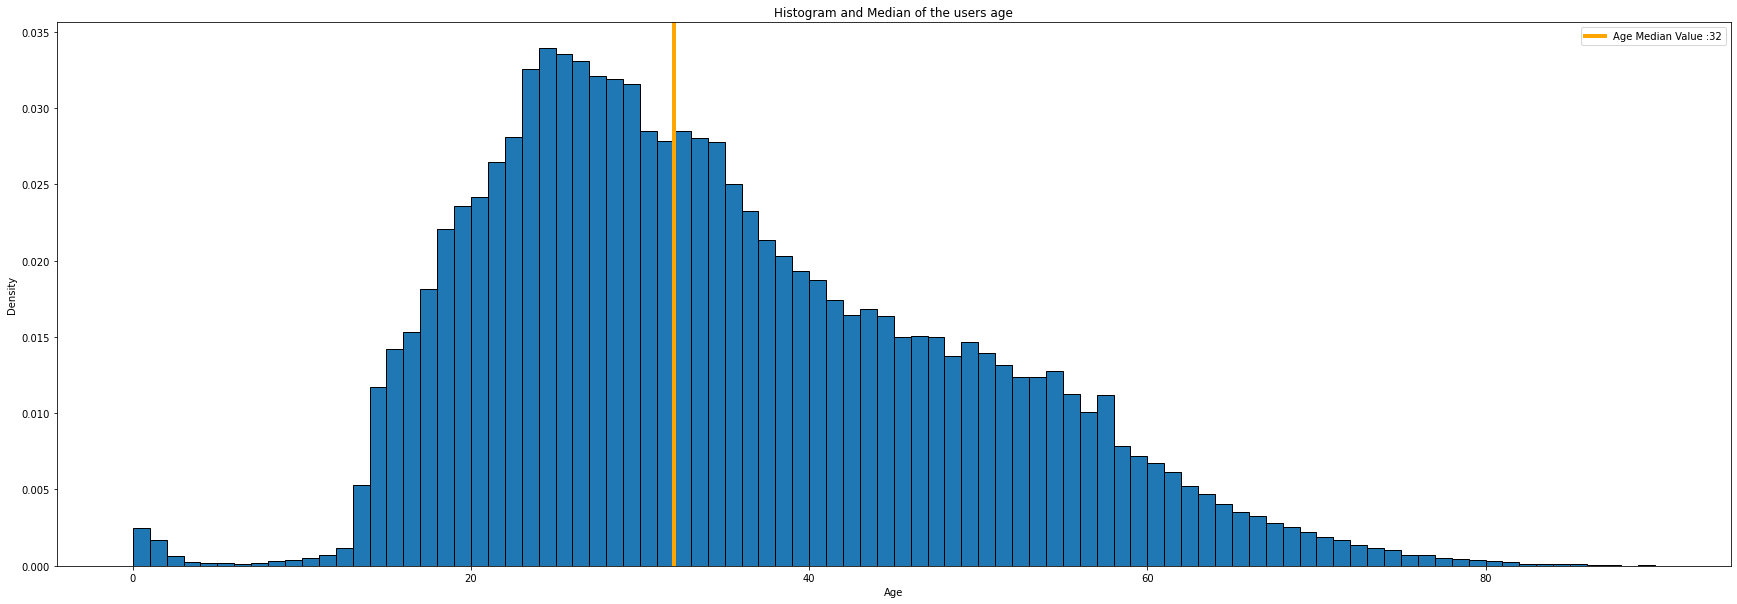

In [9]:
age_values = list(age_counts.values())
age_bins = list(age_counts.keys())
plt.hist(age_list_filtered.collect(),bins=age_bins,density=True, edgecolor='black')
plt.axvline(int(np.median(age_list_filtered.collect())),color='orange',label=f'Age Median Value :{int(np.median(age_list_filtered.collect()))}',linewidth=4)
plt.legend()
plt.title('Histogram and Median of the users age')
plt.ylabel('Density')
plt.xlabel('Age')
fig=plt.gcf()
fig.set_size_inches(30,10)

In [10]:
#USERS' Countries Location
location_fields = users_location.map(lambda x: x.replace('""','').split(','))
location_country = location_fields.map(lambda x: x[-1])

#TOP 10 Countries That The Most Users Data Collected
countryCounts = location_country.map(lambda word: (word,1)).reduceByKey(lambda a,b: a + b)
orderedCountryCounts=countryCounts.sortBy(lambda x : x[1],ascending=False)
print(f'TOP 10 Countries That The Most Data Collected: ')
orderedCountryCounts.take(10)

/Users/anunlu/miniforge3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/shuffle.py:60: UserWarning: Please install psutil to have better support with spilling
/Users/anunlu/miniforge3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/shuffle.py:60: UserWarning: Please install psutil to have better support with spilling
/Users/anunlu/miniforge3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/shuffle.py:60: UserWarning: Please install psutil to have better support with spilling


TOP 10 Countries That The Most Data Collected: 


[(' usa', 76495),
 (' spain', 12691),
 (' united kingdom', 12541),
 (' canada', 11385),
 (' germany', 10642),
 (' australia', 8896),
 (' italy', 5377),
 (' france', 3037),
 (' portugal', 2721),
 (' new zealand', 2026)]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


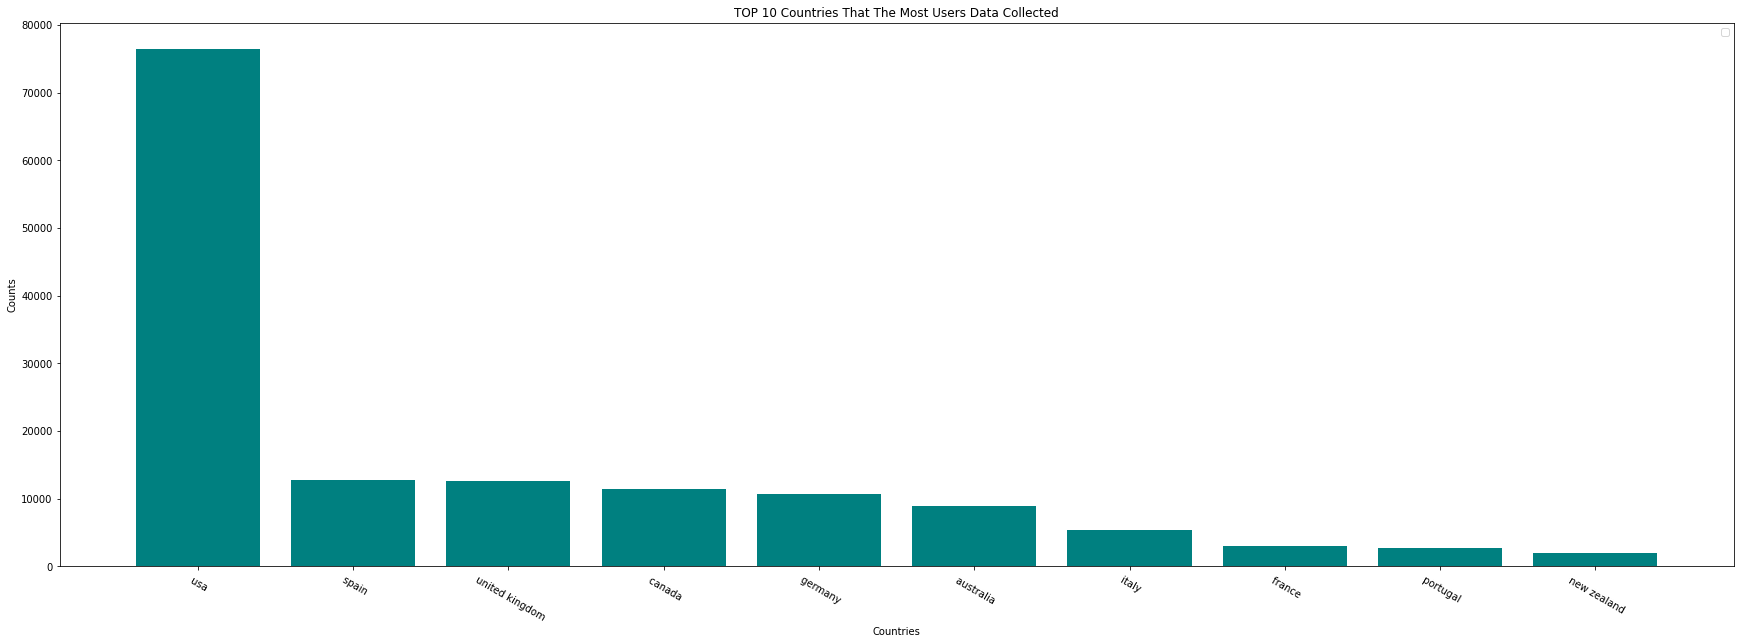

In [11]:
x = orderedCountryCounts.keys().take(10)
y = orderedCountryCounts.values().take(10)
plt.bar(x, y, color = 'teal',)
plt.xticks(rotation = -30)
plt.legend()
plt.title('TOP 10 Countries That The Most Users Data Collected')
plt.xlabel('Countries')
plt.ylabel('Counts')
fig = plt.gcf()
fig.set_size_inches(30,10)

In [12]:
rating_books_score.stats()

(count: 397245, mean: 7.601852760890598, stdev: 1.8412729800421206, max: 10.0, min: 1.0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


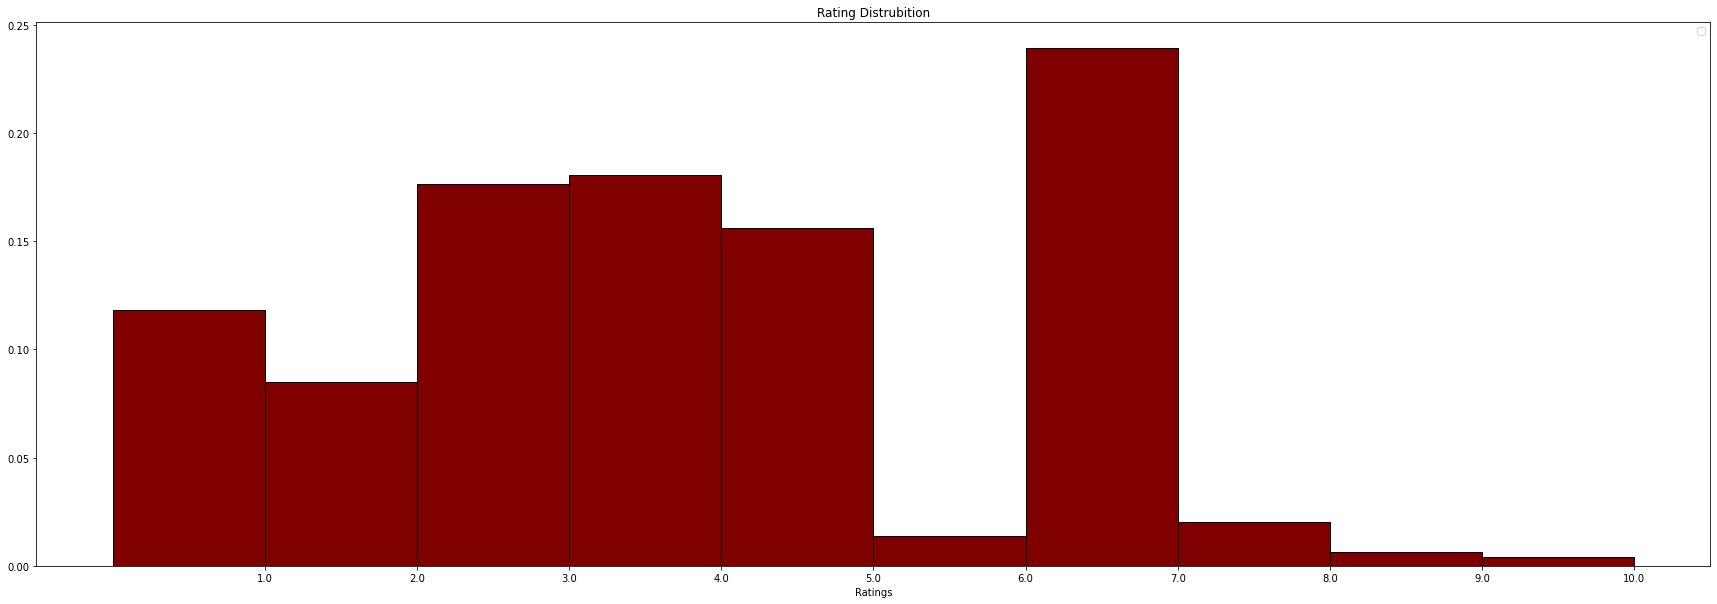

In [67]:
count_by_rating = rating_books_score.countByValue()
x_axis = np.array(sorted(count_by_rating.keys()))
y_axis = np.array([float(c) for c in count_by_rating.values()])
y_axis_normed = y_axis / y_axis.sum()
pos = np.arange(len(x_axis))
width = 1.0
ax  = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(x_axis)

plt.bar(pos, y_axis_normed, width, color = 'maroon', edgecolor='black')
plt.legend()
plt.title('Rating Distrubition')
plt.xlabel('Ratings')
fig = plt.gcf()
fig.set_size_inches(30,10)


In [14]:
raw_ratings = rating_fields.map(lambda x : x)
print('\tFirst 5 raw ratings')
raw_ratings.take(5)

	First 5 raw ratings


[['8', '2005018', '5'],
 ['8', '074322678X', '5'],
 ['8', '887841740', '5'],
 ['8', '1552041778', '5'],
 ['8', '1567407781', '6']]

In [15]:
from pyspark.mllib.recommendation import ALS
from pyspark.mllib.recommendation import Rating

ratings = raw_ratings.map(lambda x : Rating(int(x[0]), handle_isbn_str(x[1]), int(x[2])))
print("Ratings:", ratings.take(10))

train, test = ratings.randomSplit([0.7, 0.3])
testData = test.map(lambda l : (int(l[0]), int(l[1])))

Ratings: [Rating(user=8, product=2005018, rating=5.0), Rating(user=8, product=743226781, rating=5.0), Rating(user=8, product=887841740, rating=5.0), Rating(user=8, product=552041778, rating=5.0), Rating(user=8, product=567407781, rating=6.0), Rating(user=8, product=575663937, rating=6.0), Rating(user=8, product=881320189, rating=7.0), Rating(user=9, product=452264464, rating=6.0), Rating(user=10, product=477024456, rating=6.0), Rating(user=12, product=879384493, rating=10.0)]


In [16]:
start = time.time()
model10_10_01 = ALS.train(train, 10,iterations=10,seed=5041,lambda_ = 0.01)
end = time.time() - start
print("Runtime for 10_10_01: ", end)

start = time.time()
model10_10_1 = ALS.train(train, 10,iterations=10,seed=5041,lambda_ = 0.1)
end2 = time.time() - start
print("Runtime for: 10_10_1: ", end2)

start = time.time()
model10_50_01 = ALS.train(train, 10,iterations=50,seed=5041,lambda_ = 0.01)
end3 = time.time() - start
print("Runtime for: 10_50_01: ", end3)

start = time.time()
model10_50_1 = ALS.train(train, 10,iterations=50,seed=5041,lambda_ = 0.1)
end4 = time.time() - start
print("Runtime for: 10_50_1: ", end4)

start = time.time()
model10_200_01 = ALS.train(train, 10,iterations=200,seed=5041,lambda_ = 0.01)
end5 = time.time() - start
print("Runtime for: 10_200_01: ", end5)

start = time.time()
model10_200_1 = ALS.train(train, 10,iterations=200,seed=5041,lambda_ = 0.1)
end6 = time.time() - start
print("Runtime for: 10_200_1: ", end6)

22/01/16 12:57:15 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/01/16 12:57:15 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/01/16 12:57:16 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Runtime for 10_10_01:  10.75224494934082


Runtime for: 10_10_1:  5.475212812423706


Runtime for: 10_50_01:  13.218721151351929


Runtime for: 10_50_1:  11.572091102600098


Runtime for: 10_200_01:  37.990110874176025


Runtime for: 10_200_1:  34.57144618034363


In [17]:
start = time.time()
model50_10_01 = ALS.train(train, 50,iterations=10,seed=5041,lambda_ = 0.01)
end7 = time.time() - start
print("Runtime for: 50_10_01: ", end7)

start = time.time()
model50_10_1 = ALS.train(train, 50,iterations=10,seed=5041,lambda_ = 0.1)
end8 = time.time() - start
print("Runtime for: 50_10_1: ", end8)

start = time.time()
model50_50_01 = ALS.train(train, 50,iterations=50,seed=5041,lambda_ = 0.01)
end9 = time.time() - start
print("Runtime for: 50_50_01: ", end9)

start = time.time()
model50_50_1 = ALS.train(train, 50,iterations=50,seed=5041,lambda_ = 0.1)
end10 = time.time() - start
print("Runtime for: 50_50_1: ", end10)

start = time.time()
model50_200_01= ALS.train(train, 50,iterations=200,seed=5041,lambda_ = 0.01)
end11 = time.time() - start
print("Runtime for: 50_200_01: ", end11)

start = time.time()
model50_200_1 = ALS.train(train, 50,iterations=200,seed=5041,lambda_ = 0.1)
end12 = time.time() - start
print("Runtime for: 50_200_1: ", end12)

Runtime for: 50_10_01:  12.221063137054443


Runtime for: 50_10_1:  12.523693084716797


Runtime for: 50_50_01:  48.93638777732849


Runtime for: 50_50_1:  48.912221908569336


Runtime for: 50_200_01:  189.0335078239441


Runtime for: 50_200_1:  191.04163789749146


In [18]:
start = time.time()
model200_10_01 = ALS.train(train, 200,iterations=10,seed=5041,lambda_ = 0.01)
end13 = time.time() - start
print("Runtime for: 200_10_01: ", end13)

start = time.time()
model200_10_1 = ALS.train(train, 200,iterations=10,seed=5041,lambda_ = 0.1)
end14 = time.time() - start
print("Runtime for: 200_10_1: ", end14)

Runtime for: 200_10_01:  380.8048486709595


Runtime for: 200_10_1:  376.03299617767334


In [19]:
start = time.time()
model200_50_01 = ALS.train(train, 200,iterations=50,seed=5041,lambda_ = 0.01)
end15 = time.time() - start
print("Runtime for: 200_50_01: ", end15)


Runtime for: 200_50_01:  1760.4675028324127


In [22]:
start = time.time()
model200_50_1 = ALS.train(train, 200,iterations=50,seed=5041,lambda_ = 0.1)
end16 = time.time() - start
print("Runtime for: 200_50_1: ", end16)

Runtime for: 200_50_1:  1820.0759308338165


In [20]:
start = time.time()
model200_200_01 = ALS.train(train, 200,iterations=200,seed=5041,lambda_ = 0.01)
end17 = time.time() - start
print("Runtime for: 200_200_01: ", end17)


Runtime for: 200_200_01:  7455.598545074463


In [23]:
start = time.time()
model200_200_1 = ALS.train(train, 200,iterations=200,seed=5041,lambda_ = 0.1)
end18 = time.time() - start
print("Runtime for: 200_200_1: ", end18)

Runtime for: 200_200_1:  7404.228876113892


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


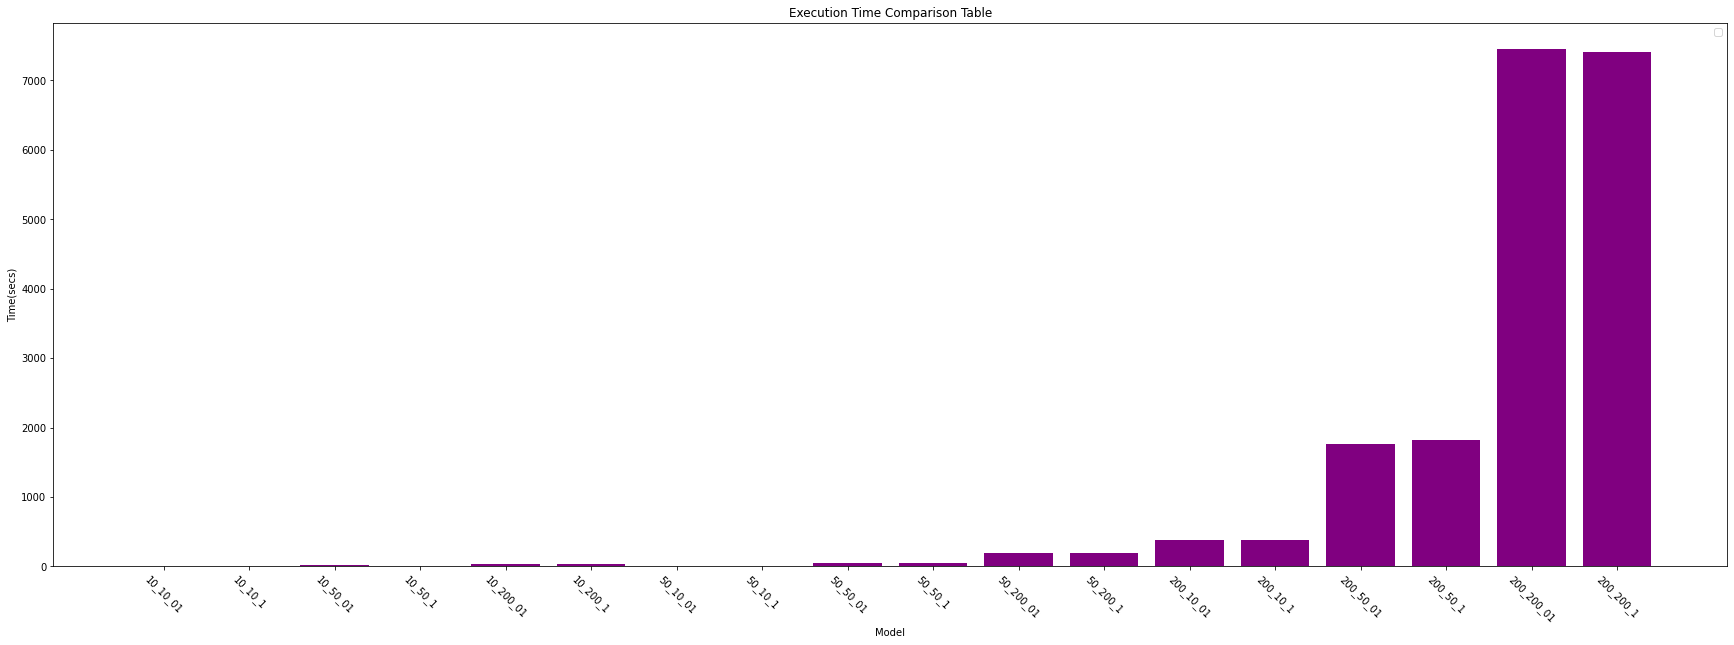

In [59]:
arr = ['10_10_01', '10_10_1', '10_50_01', '10_50_1', '10_200_01', '10_200_1', '50_10_01', '50_10_1', '50_50_01', '50_50_1', '50_200_01', '50_200_1', '200_10_01', '200_10_1', '200_50_01', '200_50_1','200_200_01', '200_200_1']
arr2 = [end, end2, end3, end4, end5, end6, end7, end8, end9, end10, end11, end12, end13, end14, end15, end16, end17, end18]
plt.bar(arr, arr2, color = 'purple')
plt.xticks(rotation = -45)
plt.legend()
plt.title('Execution Time Comparison Table')
plt.xlabel('Model')
plt.ylabel('Time(secs)')
fig = plt.gcf()
fig.set_size_inches(30,10)

In [27]:
print('\tFirst Model\'s First 10 Users and Their Item Scores: ')
model10_10_01.userFeatures().take(10)

	First Model's First 10 Users and Their Item Scores: 


[(110,
  array('d', [0.043104954063892365, -0.0526752844452858, 0.17055317759513855, 0.1293935775756836, -0.4238441288471222, 0.42954719066619873, 0.17447443306446075, 0.22338339686393738, -0.11956851184368134, -0.1727270781993866])),
 (160,
  array('d', [0.26378220319747925, 0.14461293816566467, -0.3491942882537842, 0.09207641333341599, -0.11777094006538391, -0.08207397162914276, 0.6556273102760315, -0.16278040409088135, 0.5470301508903503, -0.44641366600990295])),
 (190,
  array('d', [0.29453760385513306, 0.1970537006855011, 0.26818573474884033, -0.31558334827423096, -0.02913682535290718, 0.4166734516620636, 0.2169923186302185, -0.6416890621185303, -0.029980111867189407, -0.5143747329711914])),
 (230,
  array('d', [0.17417262494564056, -0.14698252081871033, -0.04143406078219414, 0.09493660181760788, -0.06808796525001526, 0.12537313997745514, 0.15740156173706055, 0.2791374623775482, -0.02380210906267166, 0.1253649890422821])),
 (280,
  array('d', [-0.13544894754886627, -0.097218319773

In [28]:
print('\tFirst Model\'s First 10 Items and Their User Scores: ')
model10_10_01.productFeatures().take(10)

	First Model's First 10 Items and Their User Scores: 


[(0,
  array('d', [-3.4488413333892822, 2.997420310974121, 3.7541449069976807, 3.3781442642211914, 5.378175735473633, -2.6668310165405273, 1.9575395584106445, 4.034571170806885, 0.41758444905281067, -2.9766454696655273])),
 (10,
  array('d', [-2.078667163848877, -0.3745116591453552, 1.2811903953552246, -0.13255661725997925, -0.5648002028465271, 4.343715190887451, -0.4106789827346802, -4.980429172515869, 1.6521509885787964, -0.6451542973518372])),
 (20,
  array('d', [-2.338500499725342, -0.42132559418678284, 1.4413392543792725, -0.14912620186805725, -0.6354002356529236, 4.886679172515869, -0.462013840675354, -5.602982997894287, 1.8586698770523071, -0.7257985472679138])),
 (90,
  array('d', [-0.171432763338089, -1.5183128118515015, 2.185380697250366, -4.335897922515869, -3.4567010402679443, -2.816450834274292, 3.8044519424438477, -1.4043858051300049, -3.903435468673706, -2.4384922981262207])),
 (18030,
  array('d', [-1.2769666910171509, -3.164249897003174, -0.36388346552848816, -0.015269

In [29]:
# Cosine Similarity Function
def cosineSimilarity(item_id,a,b):
    dot = np.dot(a,b)
    norma = np.linalg.norm(a)
    normb = np.linalg.norm(b)
    cos = dot / (norma * normb)
    return item_id, cos

In [41]:
# Creating Models with Using ALS Train Dataset
def modelCreate(modelItem,test,normalTest):
    itemId = 81160
    userId = 33933
    itemVector = modelItem.productFeatures().lookup(itemId)[0]
    print("Item Vector:", itemVector)

    predicted_rating = modelItem.predict(userId,itemId)
    print(f'Predicted rating for specific {itemId} and {userId}: {predicted_rating}')

    predictions = modelItem.predictAll(test)
    print("First Prediction: " ,predictions.first())
    
    K = 10
    top_k_recs = modelItem.recommendProducts(userId,K)
    print(f'Top {K} book recommendations for {userId}')
    for i in top_k_recs:
        print(i)

    print("\n///////\n")

    topKitem = modelItem.recommendUsers(itemId,K)
    print(f'Top {K} user recommendations for book: {itemId}')
    for i in topKitem:
        print(i)

    sims = modelItem.productFeatures().map(lambda data : cosineSimilarity(data[0],data[1],itemVector))
    print("\n")
    print("Cosine Similarity For Top 10: ", sims.top(10,key= lambda x : x[1]))

    print("--------------------------")
    allPredictedRatings = predictions.map(lambda l: (float(l[2])))
    print(allPredictedRatings.take(5))
    print("--------------------------")

    print("--------------------------")
    allTestRatings = normalTest.map(lambda l : (float(l[2])))
    print(allTestRatings.take(5))
    print("--------------------------")

    arr_allPredictedRatings= allPredictedRatings.collect()
    arr_allTestRatings = allTestRatings.collect()
    arr_allId = test.collect()
    
    arr = zip(arr_allId,arr_allPredictedRatings,arr_allTestRatings)
    print('First 10 Original versus Predicted ratings')
    sum = 0
    
    n = len(arr_allPredictedRatings)
    for i in range(0,n):
        difference = arr_allTestRatings[i] - arr_allPredictedRatings[i] 
        squared_difference = difference * difference
        sum = sum + squared_difference
    MSE = sum/n
    RMSE = math.sqrt(MSE)
    return [[itemVector],[predicted_rating],[predictions],[top_k_recs],[topKitem],[sims],[allPredictedRatings],[allTestRatings],[tuple(arr)],MSE,RMSE]


In [31]:
Book_ISBN_Name_Map=books_fields.map(lambda x: (handle_isbn_str(x[0]),x[1])).collectAsMap()

In [32]:
books_by_user = ratings.keyBy(lambda x : x.user).lookup(33933)
books_by_user

[Rating(user=33933, product=375706771, rating=5.0),
 Rating(user=33933, product=380713748, rating=5.0),
 Rating(user=33933, product=380763656, rating=5.0),
 Rating(user=33933, product=881500208, rating=5.0),
 Rating(user=33933, product=61097497, rating=7.0),
 Rating(user=33933, product=345384911, rating=7.0),
 Rating(user=33933, product=446360589, rating=7.0),
 Rating(user=33933, product=345298731, rating=8.0),
 Rating(user=33933, product=345339495, rating=8.0),
 Rating(user=33933, product=345353145, rating=8.0),
 Rating(user=33933, product=345368991, rating=8.0),
 Rating(user=33933, product=345380371, rating=8.0),
 Rating(user=33933, product=380710218, rating=8.0),
 Rating(user=33933, product=425154092, rating=8.0),
 Rating(user=33933, product=440213525, rating=8.0),
 Rating(user=33933, product=440214041, rating=8.0),
 Rating(user=33933, product=440217520, rating=8.0),
 Rating(user=33933, product=441003389, rating=8.0),
 Rating(user=33933, product=446515078, rating=8.0),
 Rating(user=

In [38]:
len(books_by_user)

25

In [33]:
#User Rated
books_by_user.sort(reverse = True, key = lambda x: x.rating)
print('\tUser Rated')
sc.parallelize(books_by_user[:10]).map(lambda rating: (Book_ISBN_Name_Map[rating.product], rating.rating)).collect()

	User Rated


[('Titan', 10.0),
 ('The Hippopotamus Pool (Amelia Peabody Mysteries (Paperback))', 10.0),
 ('Crystal Singer', 9.0),
 ("Winter's Tale", 9.0),
 ('Moreta: Dragonlady of Pern', 8.0),
 ("Nerilka's Story (Dragonriders of Pern (Paperback))", 8.0),
 ('Sphere', 8.0),
 ('The Chronicles of Pern: 1st Fall (The Dragonriders of Pern)', 8.0),
 ('Rising Sun', 8.0),
 ('Postmortem', 8.0)]

In [35]:
print('\tALS Recommend')
top_k_recs=model10_10_01.recommendProducts(33933,10)
sc.parallelize(top_k_recs).map(lambda rating: (Book_ISBN_Name_Map[rating.product], rating.rating)).collect()


	ALS Recommend


[("Thumper's Little Sisters Fun-To-Read Library Vol.2", 26.67714207574988),
 ('Wizard of Oz Postcards in Full Color (Card Books)', 24.934340801690563),
 ('The Shining', 24.896158185579978),
 ('If Only It Were True', 24.16467141962802),
 ('Le Combat ordinaire, tome 1', 23.70749122836607),
 ('Sense and Sensibility (Wordsworth Classics)', 23.5952725600483),
 ("I can do it myself: Featuring Jim Henson's Sesame Street muppets",
  23.583219861286658),
 ("Chicken Soup for the Couple's Soul (Chicken Soup for the Soul)",
  23.23916077858971),
 ('The Golden Compass (His Dark Materials, Book 1)', 23.114180381551783),
 ("The Magical Household: Spells &amp, Rituals for the Home (Llewellyn's Practical Magick Series)",
  22.837874005071697)]

In [77]:
print('\tALS Recommend that has Minimum RMSE Value')
top_k_recs=model50_50_01.recommendProducts(33933,10)
sc.parallelize(top_k_recs).map(lambda rating: (Book_ISBN_Name_Map[rating.product], rating.rating)).collect()

	ALS Recommend that has Minimum RMSE Value


[('Titan', 9.976675931151313),
 ('Dune (Remembering Tomorrow)', 9.897097353117973),
 ('The Return of the King (The Lord of the Rings, Part 3)', 9.67146481041655),
 ("Ender's Game (Ender Wiggins Saga (Paperback))", 9.439850386796705),
 ('Wizard and Glass (The Dark Tower, Book 4)', 9.417753279695077),
 ('The Two Towers (The Lord of the Rings, Part 2)', 9.37787168983112),
 ('The Hobbit : The Enchanting Prelude to The Lord of the Rings',
  9.312813812981306),
 ('Harry Potter and the Prisoner of Azkaban (Book 3)', 9.270850246985592),
 ('Maus a Survivors Tale: My Father Bleeds History', 9.223470860655919),
 ("My Sister's Keeper : A Novel (Picoult, Jodi)", 9.218495528553476)]

In [69]:
print('\tALS Recommend that has Minimum RMSE Value')
top_k_recs=model200_50_01.recommendProducts(33933,10)
sc.parallelize(top_k_recs).map(lambda rating: (Book_ISBN_Name_Map[rating.product], rating.rating)).collect()

	ALS Recommend that has Minimum RMSE Value


[('Titan', 9.974005912787725),
 ("Ender's Game (Ender Wiggins Saga (Paperback))", 9.338520619650806),
 ('Harry Potter and the Prisoner of Azkaban (Book 3)', 9.290752007946011),
 ('Wolves of the Calla (The Dark Tower, Book 5)', 9.140919077312903),
 ('The Return of the King (The Lord of the Rings, Part 3)', 9.077819904287406),
 ('The Calvin and Hobbes Tenth Anniversary Book', 9.02260784983266),
 ('The Fellowship of the Ring (The Lord of the Rings, Part 1)',
  9.0092766966513),
 ('The Two Towers (The Lord of the Rings, Part 2)', 8.998889770165846),
 ("Winter's Tale", 8.989993069941438),
 ('Harry Potter and the Prisoner of Azkaban (Book 3)', 8.986221159461156)]

In [55]:
print('\tALS Recommend that has Minimum RMSE Value')
top_k_recs=model200_200_01.recommendProducts(33933,10)
sc.parallelize(top_k_recs).map(lambda rating: (Book_ISBN_Name_Map[rating.product], rating.rating)).collect()

	ALS Recommend that has Minimum RMSE Value


[('Titan', 9.957538686988931),
 ("Ender's Game (Ender Wiggins Saga (Paperback))", 9.56989341135812),
 ('Harry Potter and the Goblet of Fire (Book 4)', 9.532632588052405),
 ('Harry Potter and the Prisoner of Azkaban (Book 3)', 9.424042762758077),
 ('84 Charing Cross Road', 9.410963004890537),
 ('Mangrove Squeeze', 9.323091876977323),
 ("\\Surely You're Joking, Mr. Feynman!\\: Adventures of a Curious Character",
  9.290815654546417),
 ('Harry Potter and the Chamber of Secrets Postcard Book', 9.27820770050233),
 ('Mostly True: Collected Stories &amp, Drawings', 9.124582233436957),
 ('Harry Potter and the Chamber of Secrets (Book 2)', 9.112534788801963)]

In [42]:
#Append the each model in an array for reach easily
modelsArray = []
modelsArray.append(modelCreate(model10_10_01,testData,test))
modelsArray.append(modelCreate(model10_10_1,testData,test))
modelsArray.append(modelCreate(model10_50_01,testData,test))
modelsArray.append(modelCreate(model10_50_1,testData,test))
modelsArray.append(modelCreate(model10_200_01,testData,test))
modelsArray.append(modelCreate(model10_200_1,testData,test))

modelsArray.append(modelCreate(model50_10_01,testData,test))
modelsArray.append(modelCreate(model50_10_1,testData,test))
modelsArray.append(modelCreate(model50_50_01,testData,test))
modelsArray.append(modelCreate(model50_50_1,testData,test))
modelsArray.append(modelCreate(model50_200_01,testData,test))
modelsArray.append(modelCreate(model50_200_1,testData,test))

modelsArray.append(modelCreate(model200_10_01,testData,test))
modelsArray.append(modelCreate(model200_10_1,testData,test))
modelsArray.append(modelCreate(model200_50_01,testData,test))
modelsArray.append(modelCreate(model200_50_1,testData,test))
modelsArray.append(modelCreate(model200_200_01,testData,test))
modelsArray.append(modelCreate(model200_200_1,testData,test))

Item Vector: array('d', [2.6205949783325195, 0.31286144256591797, 6.182888031005859, -0.013549390248954296, 0.9888068437576294, 0.06320922821760178, -1.1407471895217896, 0.1442173272371292, 2.5357954502105713, 4.6026434898376465])
Predicted rating for specific 81160 and 33933: 6.859238553833844
First Prediction:  Rating(user=160011, product=380759470, rating=0.5895825844499019)
Top 10 book recommendations for 33933
Rating(user=33933, product=553055747, rating=26.67714207574988)
Rating(user=33933, product=486250334, rating=24.934340801690563)
Rating(user=33933, product=385121679, rating=24.896158185579978)
Rating(user=33933, product=743406176, rating=24.16467141962802)
Rating(user=33933, product=205054252, rating=23.70749122836607)
Rating(user=33933, product=853260169, rating=23.5952725600483)
Rating(user=33933, product=307231046, rating=23.583219861286658)
Rating(user=33933, product=558746463, rating=23.23916077858971)
Rating(user=33933, product=679893105, rating=23.114180381551783)
Ra

First Prediction:  Rating(user=160011, product=380759470, rating=6.013746921074878)
Top 10 book recommendations for 33933
Rating(user=33933, product=441007317, rating=11.680209361148764)
Rating(user=33933, product=330315765, rating=11.157561099985461)
Rating(user=33933, product=574551108, rating=11.055794568356879)
Rating(user=33933, product=575601868, rating=11.019253857371199)
Rating(user=33933, product=590451790, rating=10.964871359101444)
Rating(user=33933, product=91765463, rating=10.811707120694862)
Rating(user=33933, product=373118597, rating=10.802292857149512)
Rating(user=33933, product=722321684, rating=10.658508592648435)
Rating(user=33933, product=451198352, rating=10.645831120538928)
Rating(user=33933, product=60953020, rating=10.608386891395892)

///////

Top 10 user recommendations for book: 81160
Rating(user=217389, product=81160, rating=12.54703101616197)
Rating(user=81587, product=81160, rating=12.277962407140318)
Rating(user=79323, product=81160, rating=12.2336948583

Item Vector: array('d', [0.4337233304977417, 0.8750868439674377, 0.47246816754341125, -0.946162760257721, 0.5913349986076355, 0.5957428812980652, 1.5586241483688354, 1.9455482959747314, -0.3845420181751251, 1.356164813041687, 1.0524526834487915, 0.9834745526313782, 0.2158583402633667, -1.7050352096557617, -0.8206275105476379, 1.2703756093978882, -0.052482347935438156, 0.8302388787269592, -0.36582624912261963, -0.8861056566238403, -1.849726676940918, 0.40602484345436096, -1.3334293365478516, -0.9964275360107422, 0.8746362924575806, 1.9169384241104126, -0.7227672338485718, 1.7886549234390259, -0.6584903001785278, -2.332965850830078, -0.5764893889427185, -0.9859074354171753, 0.2173212468624115, -0.6579252481460571, -2.7741451263427734, 0.27050769329071045, 1.3739511966705322, 0.8170783519744873, 1.511132001876831, 0.439937561750412, 0.6380749940872192, 0.25793731212615967, -0.3458701968193054, 3.664240837097168, -0.71665358543396, 2.9866836071014404, -1.39064359664917, -1.3836688995361328

22/01/16 18:34:31 WARN Executor: Managed memory leak detected; size = 5267604 bytes, task 0.0 in stage 11488.0 (TID 35934)
22/01/16 18:34:31 WARN ExecutionMemoryPool: Internal error: release called on 5267604 bytes but task only has 0 bytes of memory from the on-heap execution pool


First Prediction:  Rating(user=160011, product=380759470, rating=-1.2831031696680926)
Top 10 book recommendations for 33933
Rating(user=33933, product=618002243, rating=10.99837996014102)
Rating(user=33933, product=70360024, rating=10.046651769917032)
Rating(user=33933, product=618002235, rating=10.007403265829426)
Rating(user=33933, product=441813046, rating=9.999835523818923)
Rating(user=33933, product=449221490, rating=9.95363374177573)
Rating(user=33933, product=553802526, rating=9.887906018800349)
Rating(user=33933, product=684867621, rating=9.883650784140867)
Rating(user=33933, product=61000027, rating=9.732034940862631)
Rating(user=33933, product=842332261, rating=9.72838607159504)
Rating(user=33933, product=486264785, rating=9.727178832462894)

///////

Top 10 user recommendations for book: 81160
Rating(user=74287, product=81160, rating=9.99817891803752)
Rating(user=224430, product=81160, rating=7.725011713814988)
Rating(user=179734, product=81160, rating=7.508060296521164)
Rat

22/01/16 18:34:35 WARN Executor: Managed memory leak detected; size = 5267604 bytes, task 0.0 in stage 11747.0 (TID 36010)
22/01/16 18:34:35 WARN ExecutionMemoryPool: Internal error: release called on 5267604 bytes but task only has 0 bytes of memory from the on-heap execution pool


First Prediction:  Rating(user=160011, product=380759470, rating=6.4255323168349285)
Top 10 book recommendations for 33933
Rating(user=33933, product=553247778, rating=10.401546769112505)
Rating(user=33933, product=836220889, rating=10.203020935432011)
Rating(user=33933, product=553141406, rating=10.152266802643153)
Rating(user=33933, product=399132635, rating=10.067601530247728)
Rating(user=33933, product=60256656, rating=9.987282478483788)
Rating(user=33933, product=70360024, rating=9.986783170795348)
Rating(user=33933, product=726080630, rating=9.98288990690474)
Rating(user=33933, product=578591201, rating=9.92421693927879)
Rating(user=33933, product=671697994, rating=9.828312873635749)
Rating(user=33933, product=394823370, rating=9.82620535189116)

///////

Top 10 user recommendations for book: 81160
Rating(user=220095, product=81160, rating=10.99639502481786)
Rating(user=182459, product=81160, rating=10.816546359723969)
Rating(user=179791, product=81160, rating=10.783665744985306)

22/01/16 18:34:36 WARN Executor: Managed memory leak detected; size = 5267604 bytes, task 0.0 in stage 11884.0 (TID 36043)
22/01/16 18:34:36 WARN ExecutionMemoryPool: Internal error: release called on 5267604 bytes but task only has 0 bytes of memory from the on-heap execution pool


Cosine Similarity For Top 10:  [(81160, 0.9999999999999999), (1311, 0.9999999999999999), (11021, 0.9999999999999999), (41361, 0.9999999999999999), (51131, 0.9999999999999999), (51191, 0.9999999999999999), (66111, 0.9999999999999999), (68111, 0.9999999999999999), (69111, 0.9999999999999999), (181911, 0.9999999999999999)]
--------------------------
[6.4255323168349285, 5.56643607412919, 7.330795366749297, -2.224857479899124, 4.066790607234861]
--------------------------
--------------------------
[6.0, 6.0, 6.0, 6.0, 7.0]
--------------------------


First 10 Original versus Predicted ratings
Item Vector: array('d', [0.7637742161750793, -0.09342660009860992, 1.1785234212875366, -1.5658105611801147, 0.06967450678348541, -1.1649798154830933, 1.9591742753982544, 2.095982313156128, 0.40325361490249634, -0.17067812383174896, -1.5270107984542847, 0.2473658174276352, -0.45557382702827454, -1.0331884622573853, -0.48187845945358276, -0.7047642469406128, 0.6967658996582031, 0.3739161789417267, 1.020624041557312, 0.334390789270401, -0.1949867606163025, -0.7930101156234741, -0.5954208970069885, -0.5143181681632996, 0.16626746952533722, 0.8399645686149597, 0.35903024673461914, -0.8705000877380371, -0.6491926312446594, 0.786653459072113, 1.140060305595398, -0.321857213973999, -1.8839408159255981, -0.9416062235832214, -1.6317377090454102, -1.0852068662643433, 1.1628810167312622, 1.988776683807373, 0.49411627650260925, 0.6910057663917542, -0.4466194808483124, 0.3766973316669464, -1.6026350259780884, 0.5532528162002563, 0.6704389452934265, -0.78436

22/01/16 18:34:39 WARN Executor: Managed memory leak detected; size = 5267604 bytes, task 0.0 in stage 12006.0 (TID 36086)
22/01/16 18:34:39 WARN ExecutionMemoryPool: Internal error: release called on 5267604 bytes but task only has 0 bytes of memory from the on-heap execution pool


First Prediction:  Rating(user=160011, product=380759470, rating=5.545413697296577)
Top 10 book recommendations for 33933
Rating(user=33933, product=441813046, rating=9.976675931151313)
Rating(user=33933, product=441172717, rating=9.897097353117973)
Rating(user=33933, product=345339738, rating=9.67146481041655)
Rating(user=33933, product=812550706, rating=9.439850386796705)
Rating(user=33933, product=451194861, rating=9.417753279695077)
Rating(user=33933, product=618002235, rating=9.37787168983112)
Rating(user=33933, product=345339681, rating=9.312813812981306)
Rating(user=33933, product=439136369, rating=9.270850246985592)
Rating(user=33933, product=394747232, rating=9.223470860655919)
Rating(user=33933, product=743454529, rating=9.218495528553476)

///////

Top 10 user recommendations for book: 81160
Rating(user=74287, product=81160, rating=10.00031003689677)
Rating(user=49460, product=81160, rating=8.931619714690768)
Rating(user=226038, product=81160, rating=8.848704943597847)
Ratin

22/01/16 18:34:40 WARN Executor: Managed memory leak detected; size = 5267604 bytes, task 0.0 in stage 12143.0 (TID 36119)
22/01/16 18:34:40 WARN ExecutionMemoryPool: Internal error: release called on 5267604 bytes but task only has 0 bytes of memory from the on-heap execution pool


First 10 Original versus Predicted ratings
Item Vector: array('d', [0.23307862877845764, -0.4976085126399994, 0.6639963984489441, -0.028824636712670326, -0.05600482597947121, -0.09427463263273239, 0.3429943025112152, 1.0308716297149658, 0.18990929424762726, -0.1286277323961258, -1.0141873359680176, 0.0858316496014595, -0.22588805854320526, -0.08683209866285324, 0.10320878773927689, -0.09731964766979218, 0.6438212394714355, 0.4175301492214203, 0.15144957602024078, 0.08952309191226959, 0.730176568031311, -0.11860634386539459, -0.3249000310897827, -0.3881913125514984, -0.12411777675151825, 0.059145428240299225, 0.4222949147224426, 0.7377711534500122, -0.03693739324808121, 0.9718542695045471, 0.009438765235245228, 0.05502377450466156, -0.7195268869400024, -0.39689162373542786, -0.5971713662147522, 0.06730815023183823, 0.023951172828674316, 0.7938134074211121, 1.1645872592926025, 0.14347989857196808, -0.38048359751701355, -0.0453714020550251, -1.0348820686340332, 0.04837410897016525, 0.4402

22/01/16 18:34:43 WARN Executor: Managed memory leak detected; size = 5267604 bytes, task 0.0 in stage 12265.0 (TID 36162)
22/01/16 18:34:43 WARN ExecutionMemoryPool: Internal error: release called on 5267604 bytes but task only has 0 bytes of memory from the on-heap execution pool


First Prediction:  Rating(user=160011, product=380759470, rating=6.725624826937442)
Top 10 book recommendations for 33933
Rating(user=33933, product=441007317, rating=11.06904643660524)
Rating(user=33933, product=590451790, rating=10.493495626543375)
Rating(user=33933, product=689712960, rating=10.433073539026523)
Rating(user=33933, product=574551108, rating=10.330315693996313)
Rating(user=33933, product=330315765, rating=10.329204482106359)
Rating(user=33933, product=472238962, rating=9.994512952797743)
Rating(user=33933, product=965307816, rating=9.925197316488937)
Rating(user=33933, product=876054807, rating=9.841543925307546)
Rating(user=33933, product=60011785, rating=9.759422919686191)
Rating(user=33933, product=964497506, rating=9.726863398779109)

///////

Top 10 user recommendations for book: 81160
Rating(user=204500, product=81160, rating=11.543623553409535)
Rating(user=44024, product=81160, rating=11.446028037249953)
Rating(user=226038, product=81160, rating=11.3642730542268

22/01/16 18:34:44 WARN Executor: Managed memory leak detected; size = 5267604 bytes, task 0.0 in stage 12402.0 (TID 36195)
22/01/16 18:34:44 WARN ExecutionMemoryPool: Internal error: release called on 5267604 bytes but task only has 0 bytes of memory from the on-heap execution pool


First 10 Original versus Predicted ratings


Item Vector: array('d', [0.6380316615104675, -0.35542818903923035, 0.33123889565467834, -0.3450263440608978, -0.04587624967098236, -0.43415454030036926, 0.8347492814064026, 1.3253800868988037, 0.9655306935310364, -0.4404003322124481, -0.590939462184906, -0.1862993836402893, -0.4165029227733612, -0.8565104603767395, 0.533230721950531, -0.3315766155719757, -0.15208281576633453, 0.577542245388031, 0.5409577488899231, -0.12812024354934692, 0.6327205300331116, -0.3195362389087677, -0.43701568245887756, -0.2610751986503601, -0.2054610401391983, 0.33259543776512146, 0.7968421578407288, 0.7090550661087036, 0.16055843234062195, 0.8888633847236633, -0.2730655074119568, 0.38425639271736145, -1.3206236362457275, -0.977365255355835, -0.9058963656425476, -0.3095583915710449, 0.36858031153678894, 1.092201590538025, 1.3690931797027588, 0.4533728361129761, -0.20509442687034607, 0.003027615137398243, -0.7980164289474487, 0.2867264747619629, 0.35098469257354736, -0.030171411111950874, -0.3461717665195465

22/01/16 18:34:47 WARN Executor: Managed memory leak detected; size = 5267604 bytes, task 0.0 in stage 12524.0 (TID 36238)
22/01/16 18:34:47 WARN ExecutionMemoryPool: Internal error: release called on 5267604 bytes but task only has 0 bytes of memory from the on-heap execution pool


First Prediction:  Rating(user=160011, product=380759470, rating=6.796151086896542)
Top 10 book recommendations for 33933
Rating(user=33933, product=441813046, rating=9.957373590329848)
Rating(user=33933, product=812550706, rating=9.549992533831416)
Rating(user=33933, product=439136369, rating=9.500479413622251)
Rating(user=33933, product=439425220, rating=9.433053142876453)
Rating(user=33933, product=437604941, rating=9.415123254854576)
Rating(user=33933, product=964266008, rating=9.401472770884627)
Rating(user=33933, product=439139600, rating=9.363637401114367)
Rating(user=33933, product=140143505, rating=9.250181072669763)
Rating(user=33933, product=486250334, rating=9.221982902412684)
Rating(user=33933, product=743260244, rating=9.211270632146249)

///////

Top 10 user recommendations for book: 81160
Rating(user=246022, product=81160, rating=12.54546482528586)
Rating(user=32899, product=81160, rating=12.33633838072955)
Rating(user=41359, product=81160, rating=12.11315495835672)
Rat

22/01/16 18:34:51 WARN Executor: Managed memory leak detected; size = 5267604 bytes, task 0.0 in stage 12783.0 (TID 36314)
22/01/16 18:34:51 WARN ExecutionMemoryPool: Internal error: release called on 5267604 bytes but task only has 0 bytes of memory from the on-heap execution pool


First Prediction:  Rating(user=160011, product=380759470, rating=6.901368768740111)
Top 10 book recommendations for 33933
Rating(user=33933, product=722321684, rating=11.068340958090989)
Rating(user=33933, product=689712960, rating=10.822411986461354)
Rating(user=33933, product=441007317, rating=10.80619103317428)
Rating(user=33933, product=330315765, rating=10.524168937954684)
Rating(user=33933, product=876054807, rating=10.357913528484739)
Rating(user=33933, product=60011785, rating=10.324521717637387)
Rating(user=33933, product=574551108, rating=10.282599238069135)
Rating(user=33933, product=590451790, rating=10.234050880458017)
Rating(user=33933, product=375763376, rating=10.166162016477738)
Rating(user=33933, product=452731111, rating=10.059625893146626)

///////

Top 10 user recommendations for book: 81160
Rating(user=190618, product=81160, rating=11.38092196446511)
Rating(user=101888, product=81160, rating=11.135427416776931)
Rating(user=127080, product=81160, rating=11.07286810

Cosine Similarity For Top 10:  [(81160, 1.0), (1311, 1.0), (11021, 1.0), (41361, 1.0), (51131, 1.0), (51191, 1.0), (66111, 1.0), (68111, 1.0), (69111, 1.0), (181911, 1.0)]
--------------------------
[6.901368768740111, 6.144713610130086, 8.04273938569218, 2.3183240048759672, 6.334373588817965]
--------------------------
--------------------------
[6.0, 6.0, 6.0, 6.0, 7.0]
--------------------------
First 10 Original versus Predicted ratings


Item Vector: array('d', [-0.9271252751350403, 0.5611242055892944, 0.07590847462415695, -0.10055366903543472, -0.0840032622218132, -1.96119225025177, -0.17182637751102448, -0.562110185623169, -0.6098707914352417, 0.055260591208934784, -0.12193554639816284, -0.48855212330818176, -0.6559181809425354, -0.9583210349082947, 0.32640698552131653, 0.08124702423810959, 1.0288511514663696, 0.5340226888656616, -0.4174034595489502, 0.606536865234375, 0.6193623542785645, -0.67801433801651, -0.10769158601760864, 0.2796210050582886, 0.36018607020378113, 0.5853492021560669, -0.04755145683884621, 0.12965421378612518, -0.9562581777572632, 0.13443639874458313, -0.1563301384449005, 0.645779550075531, 0.24348478019237518, -0.5067095756530762, -0.05970054864883423, 0.284063458442688, 1.309326410293579, -0.9952702522277832, -0.49365469813346863, 1.5653867721557617, -0.17208033800125122, -0.6227881908416748, 0.08068851381540298, 0.4915144443511963, 0.5487216114997864, 0.02888415940105915, -0.5332066416740417, 

22/01/16 18:34:56 WARN Executor: Managed memory leak detected; size = 53952762 bytes, task 0.0 in stage 13042.0 (TID 36390)
22/01/16 18:34:56 WARN ExecutionMemoryPool: Internal error: release called on 53952762 bytes but task only has 0 bytes of memory from the on-heap execution pool


First Prediction:  Rating(user=160011, product=380759470, rating=1.4603146008870953)
Top 10 book recommendations for 33933
Rating(user=33933, product=441813046, rating=9.999840301044678)
Rating(user=33933, product=671509871, rating=8.999879605478796)
Rating(user=33933, product=345327861, rating=8.999721897626465)
Rating(user=33933, product=441003389, rating=8.000007676410974)
Rating(user=33933, product=345298731, rating=7.9999662937715765)
Rating(user=33933, product=345368991, rating=7.999937267314966)
Rating(user=33933, product=440213525, rating=7.999929727312201)
Rating(user=33933, product=425154092, rating=7.999876345499452)
Rating(user=33933, product=345353145, rating=7.9998694008212805)
Rating(user=33933, product=449221504, rating=7.999814797969336)

///////

Top 10 user recommendations for book: 81160
Rating(user=74287, product=81160, rating=9.998162260655667)
Rating(user=19265, product=81160, rating=2.9922708235625706)
Rating(user=29570, product=81160, rating=2.9734359597244753)

Cosine Similarity For Top 10:  [(81160, 0.9999999999999998), (1311, 0.9999999999999998), (11021, 0.9999999999999998), (41361, 0.9999999999999998), (51131, 0.9999999999999998), (51191, 0.9999999999999998), (66111, 0.9999999999999998), (68111, 0.9999999999999998), (69111, 0.9999999999999998), (181911, 0.9999999999999998)]
--------------------------
[1.4603146008870953, 4.690254668298531, 6.118130918193236, -0.9124497517447675, 0.8153164880356896]
--------------------------
--------------------------
[6.0, 6.0, 6.0, 6.0, 7.0]
--------------------------


First 10 Original versus Predicted ratings


Item Vector: array('d', [-1.1025817394256592, -0.27150166034698486, -0.214797243475914, 0.23478996753692627, 0.630398154258728, -0.43725109100341797, 0.2193688452243805, -0.5956672430038452, -0.41734135150909424, -0.10000806301832199, -0.11913450062274933, -0.19376806914806366, -0.04972122982144356, -0.5470037460327148, 0.288809210062027, -0.4346417188644409, 0.09167367964982986, 0.14792896807193756, 0.49852925539016724, 0.69024258852005, 0.5511118173599243, -0.918473482131958, 0.4557885527610779, 0.08497858792543411, -0.31080684065818787, 0.10001206398010254, 0.22029989957809448, -0.041319768875837326, 0.24153956770896912, 0.4542672336101532, -0.19970406591892242, -0.18721896409988403, -0.0989513248205185, -0.30724117159843445, 0.09828939288854599, -0.10300289839506149, 0.16275034844875336, -0.11407449096441269, 0.11813780665397644, -0.2368115931749344, 0.43217334151268005, -0.0710190087556839, -0.43203699588775635, -0.3268235921859741, -0.03660612925887108, 0.28519031405448914, 0.425

22/01/16 18:35:03 WARN Executor: Managed memory leak detected; size = 53952762 bytes, task 0.0 in stage 13301.0 (TID 36466)
22/01/16 18:35:03 WARN ExecutionMemoryPool: Internal error: release called on 53952762 bytes but task only has 0 bytes of memory from the on-heap execution pool


First Prediction:  Rating(user=160011, product=380759470, rating=6.374289255725686)
Top 10 book recommendations for 33933
Rating(user=33933, product=345353889, rating=9.903376873186673)
Rating(user=33933, product=567231608, rating=9.831119507444024)
Rating(user=33933, product=345360338, rating=9.794383718583575)
Rating(user=33933, product=441813046, rating=9.778314672435044)
Rating(user=33933, product=393326713, rating=9.738844987276181)
Rating(user=33933, product=345332075, rating=9.717974268762951)
Rating(user=33933, product=811824829, rating=9.697922771304473)
Rating(user=33933, product=595268821, rating=9.655102497104538)
Rating(user=33933, product=373790651, rating=9.623084606173855)
Rating(user=33933, product=553213601, rating=9.611984328070918)

///////

Top 10 user recommendations for book: 81160
Rating(user=22625, product=81160, rating=10.984615660610347)
Rating(user=182459, product=81160, rating=10.808875063154279)
Rating(user=30994, product=81160, rating=10.325048846858506)


Cosine Similarity For Top 10:  [(81160, 0.9999999999999999), (1311, 0.9999999999999999), (11021, 0.9999999999999999), (31111, 0.9999999999999999), (41361, 0.9999999999999999), (51131, 0.9999999999999999), (51191, 0.9999999999999999), (66111, 0.9999999999999999), (68111, 0.9999999999999999), (69111, 0.9999999999999999)]
--------------------------
[6.374289255725686, 5.538630254711851, 6.863022382783243, 1.794788966226735, 4.2066593713165235]
--------------------------
--------------------------
[6.0, 6.0, 6.0, 6.0, 7.0]
--------------------------


22/01/16 18:35:05 WARN Executor: Managed memory leak detected; size = 53952762 bytes, task 0.0 in stage 13438.0 (TID 36499)
22/01/16 18:35:05 WARN ExecutionMemoryPool: Internal error: release called on 53952762 bytes but task only has 0 bytes of memory from the on-heap execution pool


First 10 Original versus Predicted ratings


Item Vector: array('d', [-1.1024731397628784, 0.5102051496505737, -0.07627944648265839, 0.21493522822856903, 0.6702815294265747, -0.8360153436660767, 0.7909104228019714, -0.407297283411026, -0.4618108570575714, -0.14672306180000305, -0.2464274764060974, -0.1111028864979744, -0.5151893496513367, -0.7209082841873169, 0.338545024394989, -0.15509462356567383, 0.5734246969223022, 0.12066303193569183, 0.22954203188419342, 0.6645088195800781, 1.2870267629623413, -1.5772844552993774, 0.08260077238082886, 0.45587295293807983, -0.574291467666626, 0.47082459926605225, -0.17116209864616394, 0.08253729343414307, -0.046547550708055496, 0.36760738492012024, -0.7243088483810425, -0.2978220582008362, -0.2183200865983963, -0.05167127028107643, 0.5027483105659485, 0.41935962438583374, 0.38571321964263916, -0.3626832365989685, 0.26032522320747375, -0.6275609731674194, 0.3408643305301666, -0.23301874101161957, -0.011091496795415878, -0.11970924586057663, -0.16675573587417603, 0.38711750507354736, 0.1933054

22/01/16 18:35:10 WARN Executor: Managed memory leak detected; size = 53952762 bytes, task 0.0 in stage 13560.0 (TID 36542)
22/01/16 18:35:10 WARN ExecutionMemoryPool: Internal error: release called on 53952762 bytes but task only has 0 bytes of memory from the on-heap execution pool


First Prediction:  Rating(user=160011, product=380759470, rating=6.4880299490032645)
Top 10 book recommendations for 33933
Rating(user=33933, product=441813046, rating=9.974005912787725)
Rating(user=33933, product=812550706, rating=9.338520619650806)
Rating(user=33933, product=439136369, rating=9.290752007946011)
Rating(user=33933, product=880418568, rating=9.140919077312903)
Rating(user=33933, product=345339738, rating=9.077819904287406)
Rating(user=33933, product=836204387, rating=9.02260784983266)
Rating(user=33933, product=618002227, rating=9.0092766966513)
Rating(user=33933, product=618002235, rating=8.998889770165846)
Rating(user=33933, product=671509871, rating=8.989993069941438)
Rating(user=33933, product=439136350, rating=8.986221159461156)

///////

Top 10 user recommendations for book: 81160
Rating(user=74287, product=81160, rating=10.000880070382713)
Rating(user=29570, product=81160, rating=7.5683404801209955)
Rating(user=158917, product=81160, rating=7.285770528930018)
Rat

22/01/16 18:35:11 WARN Executor: Managed memory leak detected; size = 53952762 bytes, task 0.0 in stage 13697.0 (TID 36575)
22/01/16 18:35:11 WARN ExecutionMemoryPool: Internal error: release called on 53952762 bytes but task only has 0 bytes of memory from the on-heap execution pool


Cosine Similarity For Top 10:  [(81160, 1.0000000000000002), (1311, 1.0000000000000002), (11021, 1.0000000000000002), (41361, 1.0000000000000002), (51131, 1.0000000000000002), (51191, 1.0000000000000002), (66111, 1.0000000000000002), (68111, 1.0000000000000002), (69111, 1.0000000000000002), (181911, 1.0000000000000002)]
--------------------------
[6.4880299490032645, 5.39645143909912, 8.629683868343799, 0.8877188023314413, 3.6216931738687936]
--------------------------
--------------------------
[6.0, 6.0, 6.0, 6.0, 7.0]
--------------------------


First 10 Original versus Predicted ratings


Item Vector: array('d', [-0.5397464036941528, -0.1323588639497757, -0.06590384989976883, 0.21940642595291138, 0.3168734610080719, -0.306750625371933, 0.3211378753185272, -0.38513636589050293, -0.2249816656112671, 0.0024930224753916264, 0.02966560237109661, 0.04393967613577843, -0.1412876695394516, -0.34243836998939514, 0.22637133300304413, -0.27948254346847534, 0.051347166299819946, 0.19237357378005981, 0.32893106341362, 0.3322664499282837, 0.5488173961639404, -0.5286117792129517, 0.39468008279800415, -0.12265036255121231, -0.11591511219739914, -0.18239136040210724, -0.023124830797314644, 0.2519231140613556, 0.33059582114219666, 0.2525343894958496, -0.03630460053682327, -0.29674041271209717, -0.2761048376560211, -0.04984438419342041, 0.0540027916431427, -0.13629163801670074, -0.046918004751205444, 0.010687108151614666, 0.3789316415786743, -0.17829881608486176, 0.22290590405464172, -0.16677670180797577, -0.3788258731365204, -0.32201093435287476, 0.07276749610900879, 0.08809804916381836,

Cosine Similarity For Top 10:  [(81160, 0.9999999999999999), (1311, 0.9999999999999999), (11021, 0.9999999999999999), (41361, 0.9999999999999999), (51131, 0.9999999999999999), (51191, 0.9999999999999999), (66111, 0.9999999999999999), (68111, 0.9999999999999999), (69111, 0.9999999999999999), (181911, 0.9999999999999999)]
--------------------------
[6.745440570552617, 6.00382232934011, 8.1204014600652, 2.8089399497453815, 6.234734593664638]
--------------------------
--------------------------
[6.0, 6.0, 6.0, 6.0, 7.0]
--------------------------


First 10 Original versus Predicted ratings


Item Vector: array('d', [-0.627207338809967, -0.17036376893520355, -0.38141608238220215, 0.33100709319114685, 0.09922868758440018, -0.3701785206794739, 0.6302850842475891, -0.3914138376712799, -0.08435466885566711, 0.05734012648463249, 0.053111203014850616, -0.1363501399755478, 0.053567178547382355, -0.2334303855895996, 0.3925457000732422, -0.21738559007644653, -0.08137050271034241, 0.281011164188385, 0.3944852650165558, 0.6181751489639282, 0.7108533382415771, -0.6805854439735413, 0.1764763593673706, -0.11339189857244492, -0.2710537314414978, 0.1973256766796112, -0.24961476027965546, 0.46318233013153076, 0.2861948013305664, 0.08526801317930222, -0.13742204010486603, -0.177884042263031, -0.10882257670164108, 0.16629105806350708, -0.04445147141814232, -0.11865793913602829, -0.2945081293582916, 0.1532505750656128, 0.42199206352233887, -0.07968907058238983, 0.14120164513587952, -0.28256258368492126, -0.31080374121665955, -0.5246859788894653, -0.04541587829589844, 0.10712619870901108, 0.389

22/01/16 18:35:22 WARN Executor: Managed memory leak detected; size = 53952762 bytes, task 0.0 in stage 14078.0 (TID 36694)
22/01/16 18:35:22 WARN ExecutionMemoryPool: Internal error: release called on 53952762 bytes but task only has 0 bytes of memory from the on-heap execution pool


First Prediction:  Rating(user=160011, product=380759470, rating=6.652254027613682)
Top 10 book recommendations for 33933
Rating(user=33933, product=441813046, rating=9.957538686988931)
Rating(user=33933, product=812550706, rating=9.56989341135812)
Rating(user=33933, product=439139600, rating=9.532632588052405)
Rating(user=33933, product=439136369, rating=9.424042762758077)
Rating(user=33933, product=140143505, rating=9.410963004890537)
Rating(user=33933, product=345433068, rating=9.323091876977323)
Rating(user=33933, product=393316041, rating=9.290815654546417)
Rating(user=33933, product=439425220, rating=9.27820770050233)
Rating(user=33933, product=964266008, rating=9.124582233436957)
Rating(user=33933, product=439064872, rating=9.112534788801963)

///////

Top 10 user recommendations for book: 81160
Rating(user=32899, product=81160, rating=12.747314072567463)
Rating(user=246022, product=81160, rating=12.301770705535876)
Rating(user=229651, product=81160, rating=12.00690598376936)
Ra

Cosine Similarity For Top 10:  [(81160, 0.9999999999999998), (1311, 0.9999999999999998), (11021, 0.9999999999999998), (31111, 0.9999999999999998), (41361, 0.9999999999999998), (51131, 0.9999999999999998), (51191, 0.9999999999999998), (66111, 0.9999999999999998), (68111, 0.9999999999999998), (69111, 0.9999999999999998)]
--------------------------
[6.652254027613682, 5.571927519386017, 8.169087909008915, 1.4870960594111537, 5.2855470010686405]
--------------------------
--------------------------


22/01/16 18:35:24 WARN Executor: Managed memory leak detected; size = 53952762 bytes, task 0.0 in stage 14215.0 (TID 36727)
22/01/16 18:35:24 WARN ExecutionMemoryPool: Internal error: release called on 53952762 bytes but task only has 0 bytes of memory from the on-heap execution pool


[6.0, 6.0, 6.0, 6.0, 7.0]
--------------------------
First 10 Original versus Predicted ratings


Item Vector: array('d', [-0.44286802411079407, -0.1453826129436493, -0.028621941804885864, 0.23203644156455994, 0.33088061213493347, -0.30175772309303284, 0.34413617849349976, -0.36099255084991455, -0.23005031049251556, -0.05567796900868416, 0.01628284528851509, 0.058184657245874405, -0.11436770111322403, -0.2303505390882492, 0.19410020112991333, -0.276155024766922, 0.06782863289117813, 0.23472505807876587, 0.3293216824531555, 0.30318307876586914, 0.5632648468017578, -0.37203049659729004, 0.40835192799568176, -0.19422049820423126, -0.13646374642848969, -0.23730596899986267, -0.07455836981534958, 0.2950551509857178, 0.32353314757347107, 0.2145671397447586, 0.015365011058747768, -0.39119356870651245, -0.26178666949272156, -0.05247459188103676, 0.08507714420557022, -0.08055213838815689, -0.08213689923286438, -0.008671500720083714, 0.4193747043609619, -0.23737987875938416, 0.21729056537151337, -0.1559038609266281, -0.3014715015888214, -0.3433343172073364, 0.02147757075726986, 0.10958599299

22/01/16 18:35:28 WARN Executor: Managed memory leak detected; size = 53952762 bytes, task 0.0 in stage 14337.0 (TID 36770)
22/01/16 18:35:28 WARN ExecutionMemoryPool: Internal error: release called on 53952762 bytes but task only has 0 bytes of memory from the on-heap execution pool


First Prediction:  Rating(user=160011, product=380759470, rating=6.713060858174408)
Top 10 book recommendations for 33933
Rating(user=33933, product=722321684, rating=11.074227923308996)
Rating(user=33933, product=441007317, rating=10.893172813263648)
Rating(user=33933, product=689712960, rating=10.770104080338678)
Rating(user=33933, product=330315765, rating=10.635483658855712)
Rating(user=33933, product=574551108, rating=10.358272422061965)
Rating(user=33933, product=876054807, rating=10.343601234584797)
Rating(user=33933, product=60011785, rating=10.25255222747095)
Rating(user=33933, product=590451790, rating=10.218367776616816)
Rating(user=33933, product=375763376, rating=10.178217281598108)
Rating(user=33933, product=312203993, rating=10.142702946583487)

///////

Top 10 user recommendations for book: 81160
Rating(user=190618, product=81160, rating=11.417795665080357)
Rating(user=44024, product=81160, rating=11.348464406073976)
Rating(user=101888, product=81160, rating=11.08266761

22/01/16 18:35:30 WARN Executor: Managed memory leak detected; size = 53952762 bytes, task 0.0 in stage 14474.0 (TID 36803)
22/01/16 18:35:30 WARN ExecutionMemoryPool: Internal error: release called on 53952762 bytes but task only has 0 bytes of memory from the on-heap execution pool


Cosine Similarity For Top 10:  [(81160, 1.0), (1311, 1.0), (11021, 1.0), (41361, 1.0), (51131, 1.0), (51191, 1.0), (66111, 1.0), (68111, 1.0), (69111, 1.0), (181911, 1.0)]
--------------------------
[6.713060858174408, 6.02978006327012, 8.109232538607383, 3.1349295671859, 6.328201835928914]
--------------------------
--------------------------
[6.0, 6.0, 6.0, 6.0, 7.0]
--------------------------


First 10 Original versus Predicted ratings


In [62]:
print("Mean Squared Error Scores For Each Model:", )
c = 0
for i in modelsArray:
    print(f'Model {arr[c]} = {i[-2]}')
    c+=1

Mean Squared Error Scores For Each Model:
Model 10_10_01 = 53.34119117544696
Model 10_10_1 = 18.636155991534356
Model 10_50_01 = 22.122748588086736
Model 10_50_1 = 11.336808136605864
Model 10_200_01 = 14.227357999044946
Model 10_200_1 = 10.90573102377254
Model 50_10_01 = 36.457727810835074
Model 50_10_1 = 16.1902301464026
Model 50_50_01 = 17.618660766068086
Model 50_50_1 = 10.431964460630414
Model 50_200_01 = 12.06616164322049
Model 50_200_1 = 10.133502863434764
Model 200_10_01 = 32.22401184629114
Model 200_10_1 = 14.843206633579006
Model 200_50_01 = 16.68182390647972
Model 200_50_1 = 10.227754833152614
Model 200_200_01 = 11.894178300434724
Model 200_200_1 = 9.969889097231045


In [43]:
print("Root Mean Squared Error Scores For Each Model:", )
c = 0
for i in modelsArray:
    print(f'Model {arr[c]} = {i[-1]}')
    c+=1

Root Mean Squared Error Scores For Each Model:
Model 10_10_01 = 7.303505403259928
Model 10_10_1 = 4.316961430396889
Model 10_50_01 = 4.703482602081859
Model 10_50_1 = 3.3670176917571824
Model 10_200_01 = 3.7719170191091087
Model 10_200_1 = 3.302382628311344
Model 50_10_01 = 6.038023502010826
Model 50_10_1 = 4.023708506639442
Model 50_50_01 = 4.197458846262592
Model 50_50_1 = 3.2298551764174217
Model 50_200_01 = 3.4736380990570233
Model 50_200_1 = 3.183316331035099
Model 200_10_01 = 5.676619755302546
Model 200_10_1 = 3.8526882346718643
Model 200_50_01 = 4.084338857940135
Model 200_50_1 = 3.198086120346451
Model 200_200_01 = 3.4487937457080156
Model 200_200_1 = 3.1575131190908845


In [52]:
print('\tALS Recommend')
top_k_recs=model200_200_1.recommendProducts(33933,10)
sc.parallelize(top_k_recs).map(lambda rating: (Book_ISBN_Name_Map[rating.product], rating.rating)).collect()

	ALS Recommend


[('Titan', 9.957538686988931),
 ("Ender's Game (Ender Wiggins Saga (Paperback))", 9.56989341135812),
 ('Harry Potter and the Goblet of Fire (Book 4)', 9.532632588052405),
 ('Harry Potter and the Prisoner of Azkaban (Book 3)', 9.424042762758077),
 ('84 Charing Cross Road', 9.410963004890537),
 ('Mangrove Squeeze', 9.323091876977323),
 ("\\Surely You're Joking, Mr. Feynman!\\: Adventures of a Curious Character",
  9.290815654546417),
 ('Harry Potter and the Chamber of Secrets Postcard Book', 9.27820770050233),
 ('Mostly True: Collected Stories &amp, Drawings', 9.124582233436957),
 ('Harry Potter and the Chamber of Secrets (Book 2)', 9.112534788801963)]

In [61]:
modelsArray[-1]

[[array('d', [-0.44286802411079407, -0.1453826129436493, -0.028621941804885864, 0.23203644156455994, 0.33088061213493347, -0.30175772309303284, 0.34413617849349976, -0.36099255084991455, -0.23005031049251556, -0.05567796900868416, 0.01628284528851509, 0.058184657245874405, -0.11436770111322403, -0.2303505390882492, 0.19410020112991333, -0.276155024766922, 0.06782863289117813, 0.23472505807876587, 0.3293216824531555, 0.30318307876586914, 0.5632648468017578, -0.37203049659729004, 0.40835192799568176, -0.19422049820423126, -0.13646374642848969, -0.23730596899986267, -0.07455836981534958, 0.2950551509857178, 0.32353314757347107, 0.2145671397447586, 0.015365011058747768, -0.39119356870651245, -0.26178666949272156, -0.05247459188103676, 0.08507714420557022, -0.08055213838815689, -0.08213689923286438, -0.008671500720083714, 0.4193747043609619, -0.23737987875938416, 0.21729056537151337, -0.1559038609266281, -0.3014715015888214, -0.3433343172073364, 0.02147757075726986, 0.10958599299192429, 0.3